In [1]:
import numpy as np
from IPython.display import Image

# Project Molecular Dynamics

# 1. Structure

## 1.1 General Structure

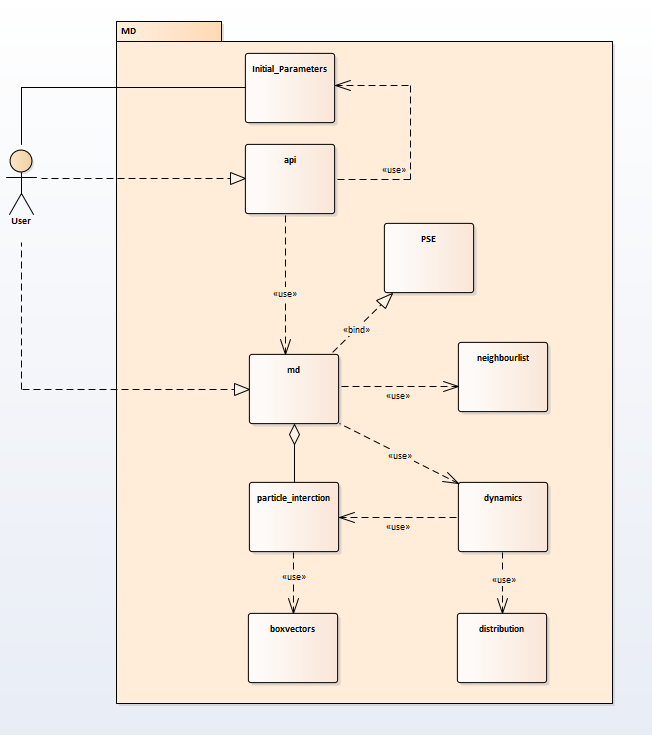

In [6]:
Image(filename='Class_Model.PNG')

## 1.2 Input file

In [1]:
#############################################################################################
########################################## PACKAGES #########################################
#############################################################################################

import numpy as np

#############################################################################################
##################################### INITIAL PARAMETERS ####################################
#############################################################################################
# Fill these before you start the Simulation

# Substance to be simulated
# e.g NaCl
Symbols = np.array(['Na','Cl'])

# Stochiometric Coefficients
# e.g. Na_1_Cl_1
Coefficients = np.array([1,1])

# Atomic Charges in e
# e.g. Na_1+_Cl_1-
Charges = np.array([1.0 ,-1.0])

# Number of Particles
N = 32

# Boxsize in Angstroem
L_x=22.56
L_y=22.56
L_z=22.56


# LJ Cutoff Radius in Angstroem
r_cut_LJ = 0.4*L_x
assert r_cut_LJ < L_x/2, "LJ cutoff radius must be smaller than half a box length"

# Accuracy Factor
# the cutoff-error is given by exp(-p)
p_error = 10.0

# Temperature in Kelvin
T = 100 # Kelvin 

# Timestep in seconds
timestep = 0.1e-15

#Characetristic coupling time for Thermostat in femtoseconds
# must be larger than dt
tau = 100

#Switch Radius in Angstroem
r_switch = r_cut_LJ*0.9

#Number of itereations
N_steps=20

#stopping condition for the loop
threshold=1e-11

#Every how many iterations the Energy should be saved
Energy_save=1

#Every how many iterations the Positions should be saved
Frame_save=1

#Every how many itereations the Temperature of the system should be saved
Temperature_save=1

#max displacement in the minimazation step
max_displacement = 0.05


#############################################################################################
#############################################################################################
#############################################################################################

#############################################################################################
############################### DO NOT CHANGE THESE LINES !!! ###############################
#############################################################################################

assert tau>timestep, "tau must be larger than timestep"
assert r_switch < r_cut_LJ, "switch radius must be smaller than LJ cutoff Radius"

# Summarizing Dimension in one array
L = np.array([L_x, L_y, L_z])

#Reassignment Probability
p_rea = timestep/tau

##number of Boxes to consider for short ranged Potential
n_boxes_short_range = ( np.ceil((L_x / (float)(2))/np.max(L)) ).astype(int)

dt = timestep/48.8882*1e15 #correcting Unit s --> dt = 48.8882 fs = 48.8882e-15 s

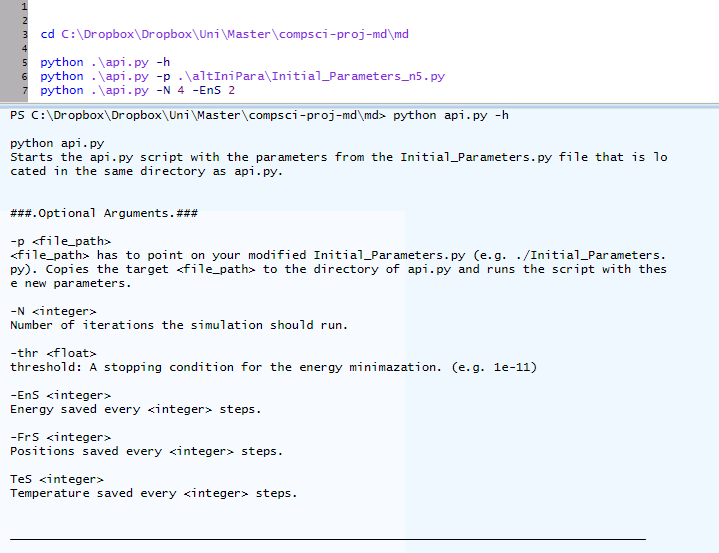

In [2]:
Image(filename='Help_And_Script.PNG')

## 1.3 Class "System"

- get_Labels(self)


- get_LJ_parameter(self)

## 1.4 Class "md"

### Functions available for user

- get_neighbourlist_coulomb(self)


- get_neighbourlist_LJ(self)


- get_potential(self)


- get_energy(self)


- get_forces(self)


- get_Temperature(self)


- propagate_system(self)


- get_traj(self, N_steps, Energy_save, Temperature_save, Frame_save, path)


- minmimize_Energy(self, N_steps, threshold, Energy_save, Frame_save, constant, path)

## 1.5 Class "neighbourlist"

- compute_neighbourlist(self, R, box_length, r_cutoff)

Function returns list of neighbors within the cutoff radius for all particles:

In [1]:
def compute_neighbourlist(R, box_length, r_cutoff):
    neighbors = {}
    distances = {}
    N, dim = np.shape(R)
    # divide simulation box into small cells of equal size r_c >= r_cutoff
    # (assume same size in all N dimensions)
    n_cells = np.int(box_length / r_cutoff)
    r_c = box_length / n_cells
    head = [-1] * (n_cells)**3
    cllist = [-1] * N
    for i in range(N):
        #empty list of neighbors
        neighbors[i] = []
        distances[i] = []
        # cell index of particle by its position
        x = np.int(R[i][0] / r_c)
        y = np.int(R[i][1] / r_c)
        z = np.int(R[i][2] / r_c)
        cell_index = x*n_cells*n_cells + y*n_cells + z
        cllist[i] = head[cell_index]
        # The last one goes to the head
        head[cell_index] = i
        
        # For all cells: Look for neighbors within neighboring cells
        for cell in range(n_cells**3):
            x = np.int(cell/(n_cells*n_cells)) % n_cells
            y = np.int(cell/n_cells) % n_cells
            z = cell % n_cells
            
            nb = np.empty(3)
            r_shift = np.empty(3)
            # Scan the neighboring cells (including itself)
            nb[0] = x-1
            nb[1] = y-1
            nb[2] = z-1
            for nbcell_ind in range(3**3):
                if nbcell_ind != 0:
                    nb[2] += 1
                    if nbcell_ind % 3 == 0:
                        nb[2] = z-1
                        nb[1] += 1
                    if nbcell_ind % 9 == 0:
                        nb[1] = y-1
                        nb[0] += 1

                # Shift image position of simulation box?
                for d in range(3):
                    if (nb[d] < 0):
                        r_shift[d] = -box_length
                    elif (nb[d]>=n_cells):
                        r_shift[d] = box_length
                    else:
                        r_shift[d] = 0.0
                  
                # Calculate cell index nbcell of neighbor cell
                nbcell = np.int(((nb[0]+n_cells)%n_cells)* n_cells*n_cells
                          + ((nb[1]+n_cells)%n_cells) * n_cells 
                          + ((nb[2]+n_cells)%n_cells))
                # where % pulls index back into appr. range

                # Scan particle i in cell 
                i = head[cell]
                while(i != -1):
                # Scan particle j in cell nbcell
                    j = head[nbcell]
                    while(j != -1):
                    # Avoid double counting of pair (i, j)
                        if (i<j):
                            # dist of i, j smaller than cutoff?
                            dist = np.linalg.norm(R[i]-(R[j]+r_shift))
                            if (dist <= r_cutoff):
                                neighbors[i].append(j)
                                distances[i].append(dist)
                                neighbors[j].append(i)
                                distances[j].append(dist)


                        j = cllist[j]
                    i = cllist[i]
                                    
        return neighbors, distances

In [2]:
def naive_neighborlist(R, box_length, r_cutoff):
    naiveneighbors = {}
    distances = {}
    dx = np.empty(3)
    for i in range(N):
        naiveneighbors[i] = []
        distances[i] = []
        for j in range(N):
            d = 0.0
            for x in range(3):
                dx[x] = R[i][x]-R[j][x]
                if (dx[x] < -box_length/2):
                    dx[x] += box_length
                elif (dx[x] > box_length/2):
                    dx[x] -= box_length
                    
                d += dx[x]**2
            d = np.sqrt(d)
            if (d <= r_cutoff):
                if (i>j):
                    naiveneighbors[i].append(j)
                    distances[i].append(d)
                    naiveneighbors[j].append(i)
                    distances[j].append(d)

    return naiveneighbors, distances

In [3]:
import numpy as np
import time
N = 300
R = np.random.rand(N,3)
box_length = 1.0
r_cutoff = 0.11

a = time.clock()
n1, dist1 = compute_neighbourlist(R, box_length, r_cutoff)
b = time.clock()
print("cell list: ", str(b-a), "seconds")

c = time.clock()
n2, dist2 = naive_neighborlist(R, box_length, r_cutoff)
d = time.clock()
print("naive impl.: ", str(d-c), "seconds")

('cell list: ', '0.278773', 'seconds')
('naive impl.: ', '1.018657', 'seconds')


## 1.6 Class "directions"

- get_directions(self, n_boxes)

In [8]:
def get_directions(n_boxes):
    """ Returns
    -------------------
    K (2*n_boxes+1)**3 x 3 Array
    Each Row of the Array denotes a 1x3 Array that points to a unique dircetion"""
        
    assert type(n_boxes) is int, "n_boxes must be an integer"
    # number of boxes in system (including all copies)
    N_total_boxes = (2*n_boxes+1)**3
    
    # create natural numbers starting from 0 in decimal system
    decimals = np.arange(N_total_boxes)
    
    # convert natural numbers to q-adic representation
    base = (2*n_boxes+1)

    K = np.zeros((N_total_boxes,3))

    K[:,0] = np.floor(decimals/base**2)                      # q²
    K[:,1] = np.floor((decimals - K[:,0]*base**2) / base)    # q¹
    K[:,2] = decimals - K[:,0]*base**2 - K[:,1]*base         # q⁰

    K -= n_boxes       # highest coefficient is number of boxes in one direction
    return K

In [9]:
get_directions(1)

array([[-1., -1., -1.],
       [-1., -1.,  0.],
       [-1., -1.,  1.],
       [-1.,  0., -1.],
       [-1.,  0.,  0.],
       [-1.,  0.,  1.],
       [-1.,  1., -1.],
       [-1.,  1.,  0.],
       [-1.,  1.,  1.],
       [ 0., -1., -1.],
       [ 0., -1.,  0.],
       [ 0., -1.,  1.],
       [ 0.,  0., -1.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  1.],
       [ 0.,  1., -1.],
       [ 0.,  1.,  0.],
       [ 0.,  1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1.,  0.],
       [ 1., -1.,  1.],
       [ 1.,  0., -1.],
       [ 1.,  0.,  0.],
       [ 1.,  0.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1.,  0.],
       [ 1.,  1.,  1.]])

### k-vectors

$$ \mathbf{k} = \frac{2 \pi}{L} \left( \begin{matrix} k_x \\k_y \\ k_z \end{matrix} \right) ~ ~ , ~ ~ k_x, k_y, k_z \in \mathbb{Z}  $$

$$ k_{cut} = \frac{2 \pi}{L} \sqrt{k_x^2 + k_y^2 + k_z^2}  $$

$$ k_{max} = \frac{k_{cut} L}{2 \pi}       $$


- delete (0,0,0)
- delete all k-vectors longer than cutoff

## 1.7 Class "coulomb"

- compute_optimal_cutoff(self, Positions, Labels, L, p_error)



- compute_potential(self,labels,positions, neighbours, distances)

    short-range-potential + long-range-potential
    
    
    
- compute_energy(self,labels,positions, neighbours, distances)

    short-range-energy + long-range-energy - self-energy
    
    
    
- compute_forces(self,Positions, Labels,L)
    
    short-range-forces + long-range-forces

### optimal cutoff

$$
R_{opt} = \left( \frac{p}{\pi} \right)^\frac{1}{2} \cdot \left( \frac{t_k}{t_r} \right)^\frac{1}{6} \cdot \left( \frac{L}{N^\frac{1}{6}} \right) \\
with \left( \frac{t_k}{t_r} \right) \approx \frac{T_k}{T_r} \cdot \frac{8 \cdot \pi \cdot N^{2} \cdot R_{cut}^{3}}{V \cdot L^{3} \cdot K_{cut}^{3}}  
$$

$$
K_{opt} = \frac{2 \cdot p}{R_{opt}} \\
\sigma_{opt} = \frac{\sqrt{2 \cdot p}}{K_{opt}}
$$

### 1.7.1 Short range potential and energy

Potential of the charge i at point  $\vec{r}$:$$\phi^S _i(\vec{r}) = \frac{q_i}{4\pi\epsilon _0|\vec{r}_i-\vec{r}|} \left[ erfc\left( \frac{|\vec{r}_i-\vec{r}|}{\sqrt{2}\sigma}\right)\right]$$

Potential at point  $\vec{r}_i$:$$ \phi^S \color{red}{_i} = \color{red}{\sum_{j=1,j!=i}^{N}}\frac{q_j}{4\pi\epsilon _0\color{red}{|\vec{r}_i-\vec{r}_j|}} \left[ erfc\left( \frac{\color{red}{|\vec{r}_i-\vec{r}_j|}}{\sqrt{2}\sigma}\right)\right]$$

Total Energy$$ E^S = \frac{1}{\color{red}{8}\pi\epsilon _0} \color{red}{\sum_{\vec{n}}} \sum_{i=1,i!=j}^{N} \frac{\color{red}{q_i} q_j}{|\vec{r}_i-\vec{r}_j|} \left[ erfc\left( \frac{|\vec{r}_i-\vec{r}_j|}{\sqrt{2}\sigma}\right)\right]$$

### 1.7.2 Long range potential and energy

#### long range potential

$$
\phi_L(r) = \frac{1}{V \cdot \epsilon_0} \cdot \sum_{\mathbf k} \sum_{j=1}^{N} q_j \cdot e^{i \left< \mathbf k, r\right>} \cdot e^{-i \left< \mathbf k, r_j\right>} \cdot \frac{e^{\frac{-\sigma^{2} \cdot k^{2}}{2}}}{k^{2}}
$$

In [ ]:
vector = np.sum(np.square(self.k_list), axis = 1)

$$
\begin{align*}
vector = \left( \begin{matrix}
k_{11}^{2} + k_{12}^{2} + k_{13}^{2} \\
k_{21}^{2} + k_{22}^{2} + k_{23}^{2} \\
\vdots \\
k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}
\end{matrix} \right) 
\end{align*}
$$

In [ ]:
vector = np.divide(np.exp(-np.multiply(vector, self.std ** 2 / (float)(2))), vector)

$$ 
\begin{align*}
vector = 
\left( \begin{matrix}
e^{- \frac{(k_{11}^{2} + k_{12}^{2} + k_{13}^{2}) \cdot \sigma^{2}}{2}} \\
e^{- \frac{(k_{21}^{2} + k_{22}^{2} + k_{23}^{2}) \cdot \sigma^{2}}{2}} \\
\vdots \\
e^{- \frac{(k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}) \cdot \sigma^{2}}{2}}
\end{matrix} \right)
\oslash
\left( \begin{matrix}
k_{11}^{2} + k_{12}^{2} + k_{13}^{2} \\
k_{21}^{2} + k_{22}^{2} + k_{23}^{2} \\
\vdots \\
k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}
\end{matrix} \right) \\
=
\left( \begin{matrix}
\frac{e^{- \frac{(k_{11}^{2} + k_{12}^{2} + k_{13}^{2}) \cdot \sigma^{2}}{2}}}{k_{11}^{2} + k_{12}^{2} + k_{13}^{2}} \\
\frac{e^{- \frac{(k_{21}^{2} + k_{22}^{2} + k_{23}^{2}) \cdot \sigma^{2}}{2}}}{k_{21}^{2} + k_{22}^{2} + k_{23}^{2}} \\
\vdots \\
\frac{e^{- \frac{(k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}) \cdot \sigma^{2}}{2}}}{k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}}
\end{matrix} \right)
\end{align*}
$$

In [ ]:
matrix = np.dot(self.k_list, np.transpose(positions))

$$ 
\begin{align*}
matrix =
\left( \begin{matrix}
k_{11} & k_{12} & k_{13} \\
k_{21} & k_{22} & k_{23} \\
\vdots & \vdots & \vdots \\
k_{m1} & k_{m2} & k_{m3}
\end{matrix} \right) 
\cdot
\left( \begin{matrix}
x_{1} & x_{2} & \cdots & x_{n} \\
y_{1} & y_{2} & \cdots & y_{n} \\
z_{1} & z_{2} & \cdots & z_{n}
\end{matrix} \right) \\
=
\left( \begin{matrix}
k_{11} \cdot x_{1} + k_{12} \cdot y_{1} + k_{13} \cdot z_{1} &
k_{11} \cdot x_{2} + k_{12} \cdot y_{2} + k_{13} \cdot z_{2} &
\cdots &
k_{11} \cdot x_{n} + k_{12} \cdot y_{n} + k_{13} \cdot z_{n}\\
k_{21} \cdot x_{1} + k_{22} \cdot y_{1} + k_{23} \cdot z_{1} &
k_{21} \cdot x_{2} + k_{22} \cdot y_{2} + k_{23} \cdot z_{2} &
\cdots &
k_{21} \cdot x_{n} + k_{22} \cdot y_{n} + k_{23} \cdot z_{n}\\
\vdots & \vdots & \ddots & \vdots \\
k_{m1} \cdot x_{1} + k_{m2} \cdot y_{1} + k_{m3} \cdot z_{1} &
k_{m1} \cdot x_{2} + k_{m2} \cdot y_{2} + k_{m3} \cdot z_{2} &
\cdots &
k_{m1} \cdot x_{n} + k_{m2} \cdot y_{n} + k_{m3} \cdot z_{n}
\end{matrix} \right)
\end{align*}
$$

In [ ]:
vector = np.multiply(vector, np.dot(np.exp(-1j * matrix), charges))

$$
\begin{align*}
{np.dot(np.exp(-1j * matrix), charges)} =
\left( \begin{matrix}
e^{-1j \cdot (k_{11} \cdot x_{1} + k_{12} \cdot y_{1} + k_{13} \cdot z_{1})} &
e^{-1j \cdot (k_{11} \cdot x_{2} + k_{12} \cdot y_{2} + k_{13} \cdot z_{2})} &
\cdots &
e^{-1j \cdot (k_{11} \cdot x_{n} + k_{12} \cdot y_{n} + k_{13} \cdot z_{n})}\\
e^{-1j \cdot (k_{21} \cdot x_{1} + k_{22} \cdot y_{1} + k_{23} \cdot z_{1})} &
e^{-1j \cdot (k_{21} \cdot x_{2} + k_{22} \cdot y_{2} + k_{23} \cdot z_{2})} &
\cdots &
e^{-1j \cdot (k_{21} \cdot x_{n} + k_{22} \cdot y_{n} + k_{23} \cdot z_{n})}\\
\vdots & \vdots & \ddots & \vdots \\
e^{-1j \cdot (k_{m1} \cdot x_{1} + k_{m2} \cdot y_{1} + k_{m3} \cdot z_{1})} &
e^{-1j \cdot (k_{m1} \cdot x_{2} + k_{m2} \cdot y_{2} + k_{m3} \cdot z_{2})} &
\cdots &
e^{-1j \cdot (k_{m1} \cdot x_{n} + k_{m2} \cdot y_{n} + k_{m3} \cdot z_{n})}
\end{matrix} \right)
\cdot
\left( \begin{matrix}
q1 \\
q2 \\
\vdots \\
qn
\end{matrix} \right) \\
=
\left( \begin{matrix}
q1 \cdot e^{-1j \cdot (k_{11} \cdot x_{1} + k_{12} \cdot y_{1} + k_{13} \cdot z_{1})} +
q2 \cdot e^{-1j \cdot (k_{11} \cdot x_{2} + k_{12} \cdot y_{2} + k_{13} \cdot z_{2})} +
\cdots +
qn \cdot e^{-1j \cdot (k_{11} \cdot x_{n} + k_{12} \cdot y_{n} + k_{13} \cdot z_{n})}\\
q1 \cdot e^{-1j \cdot (k_{21} \cdot x_{1} + k_{22} \cdot y_{1} + k_{23} \cdot z_{1})} +
q2 \cdot e^{-1j \cdot (k_{21} \cdot x_{2} + k_{22} \cdot y_{2} + k_{23} \cdot z_{2})} +
\cdots +
qn \cdot e^{-1j \cdot (k_{21} \cdot x_{n} + k_{22} \cdot y_{n} + k_{23} \cdot z_{n})}\\
\vdots \\
q1 \cdot e^{-1j \cdot (k_{m1} \cdot x_{1} + k_{m2} \cdot y_{1} + k_{m3} \cdot z_{1})} +
q2 \cdot e^{-1j \cdot (k_{m1} \cdot x_{2} + k_{m2} \cdot y_{2} + k_{m3} \cdot z_{2})} +
\cdots +
qn \cdot e^{-1j \cdot (k_{m1} \cdot x_{n} + k_{m2} \cdot y_{n} + k_{m3} \cdot z_{n})}
\end{matrix} \right) \\
=
\left( \begin{matrix}
\sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{11} \cdot x_{i} + k_{12} \cdot y_{i} + k_{13} \cdot z_{i})} \\
\sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{21} \cdot x_{i} + k_{22} \cdot y_{i} + k_{23} \cdot z_{i})} \\
\vdots \\
\sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{m1} \cdot x_{i} + k_{m2} \cdot y_{i} + k_{m3} \cdot z_{i})}
\end{matrix} \right)
\end{align*}
$$

In [ ]:
vector = np.multiply(vector, np.dot(np.exp(-1j * matrix), charges))

$$
\begin{align*}
vector =
\left( \begin{matrix}
\frac{e^{- \frac{(k_{11}^{2} + k_{12}^{2} + k_{13}^{2}) \cdot \sigma^{2}}{2}}}{k_{11}^{2} + k_{12}^{2} + k_{13}^{2}} \\
\frac{e^{- \frac{(k_{21}^{2} + k_{22}^{2} + k_{23}^{2}) \cdot \sigma^{2}}{2}}}{k_{21}^{2} + k_{22}^{2} + k_{23}^{2}} \\
\vdots \\
\frac{e^{- \frac{(k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}) \cdot \sigma^{2}}{2}}}{k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}}
\end{matrix} \right)
\odot
\left( \begin{matrix}
\sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{11} \cdot x_{i} + k_{12} \cdot y_{i} + k_{13} \cdot z_{i})} \\
\sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{21} \cdot x_{i} + k_{22} \cdot y_{i} + k_{23} \cdot z_{i})} \\
\vdots \\
\sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{m1} \cdot x_{i} + k_{m2} \cdot y_{i} + k_{m3} \cdot z_{i})}
\end{matrix} \right) \\
=
\left( \begin{matrix}
\frac{e^{- \frac{(k_{11}^{2} + k_{12}^{2} + k_{13}^{2}) \cdot \sigma^{2}}{2}}}{k_{11}^{2} + k_{12}^{2} + k_{13}^{2}} \cdot \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{11} \cdot x_{i} + k_{12} \cdot y_{i} + k_{13} \cdot z_{i})} \\
\frac{e^{- \frac{(k_{21}^{2} + k_{22}^{2} + k_{23}^{2}) \cdot \sigma^{2}}{2}}}{k_{21}^{2} + k_{22}^{2} + k_{23}^{2}} \cdot \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{21} \cdot x_{i} + k_{22} \cdot y_{i} + k_{23} \cdot z_{i})} \\
\vdots \\
\frac{e^{- \frac{(k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}) \cdot \sigma^{2}}{2}}}{k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}} \cdot \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{m1} \cdot x_{i} + k_{m2} \cdot y_{i} + k_{m3} \cdot z_{i})}
\end{matrix} \right)
\end{align*}
$$

In [ ]:
return_vector = np.dot(np.exp(1j*np.transpose(matrix)), vector)

$$
\begin{align*}
returnvector =
\left( \begin{matrix}
e^{1j \cdot (k_{11} \cdot x_{1} + k_{12} \cdot y_{1} + k_{13} \cdot z_{1})} &
e^{1j \cdot (k_{21} \cdot x_{1} + k_{22} \cdot y_{1} + k_{23} \cdot z_{1})} &
\cdots &
e^{1j \cdot (k_{m1} \cdot x_{1} + k_{m2} \cdot y_{1} + k_{m3} \cdot z_{1})} \\
e^{1j \cdot (k_{11} \cdot x_{2} + k_{12} \cdot y_{2} + k_{13} \cdot z_{2})} &
e^{1j \cdot (k_{21} \cdot x_{2} + k_{22} \cdot y_{2} + k_{23} \cdot z_{2})} &
\cdots &
e^{1j \cdot (k_{m1} \cdot x_{2} + k_{m2} \cdot y_{2} + k_{m3} \cdot z_{2})} \\
\vdots & \vdots & \ddots & \vdots \\
e^{1j \cdot (k_{11} \cdot x_{n} + k_{12} \cdot y_{n} + k_{13} \cdot z_{n})} &
e^{1j \cdot (k_{21} \cdot x_{n} + k_{22} \cdot y_{n} + k_{23} \cdot z_{n})} &
\cdots &
e^{1j \cdot (k_{m1} \cdot x_{n} + k_{m2} \cdot y_{n} + k_{m3} \cdot z_{n})}
\end{matrix} \right)
\cdot
\left( \begin{matrix}
\frac{e^{- \frac{(k_{11}^{2} + k_{12}^{2} + k_{13}^{2}) \cdot \sigma^{2}}{2}}}{k_{11}^{2} + k_{12}^{2} + k_{13}^{2}} \cdot \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{11} \cdot x_{i} + k_{12} \cdot y_{i} + k_{13} \cdot z_{i})} \\
\frac{e^{- \frac{(k_{21}^{2} + k_{22}^{2} + k_{23}^{2}) \cdot \sigma^{2}}{2}}}{k_{21}^{2} + k_{22}^{2} + k_{23}^{2}} \cdot \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{21} \cdot x_{i} + k_{22} \cdot y_{i} + k_{23} \cdot z_{i})} \\
\vdots \\
\frac{e^{- \frac{(k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}) \cdot \sigma^{2}}{2}}}{k_{m1}^{2} + k_{m2}^{2} + k_{m3}^{2}} \cdot \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{m1} \cdot x_{i} + k_{m2} \cdot y_{i} + k_{m3} \cdot z_{i})}
\end{matrix} \right) \\
=
\left( \begin{matrix}
\sum_{o=1}^{m} \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{o1} \cdot x_{i} + k_{o2} \cdot y_{i} + k_{o3} \cdot z_{i})} \cdot e^{1j \cdot (k_{o1} \cdot x_{1} + k_{o2} \cdot y_{1} + k_{o3} \cdot z_{1})} \cdot \frac{e^{- \frac{(k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}) \cdot \sigma^{2}}{2}}}{k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}} \\
\sum_{o=1}^{m} \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{o1} \cdot x_{i} + k_{o2} \cdot y_{i} + k_{o3} \cdot z_{i})} \cdot e^{1j \cdot (k_{o1} \cdot x_{2} + k_{o2} \cdot y_{2} + k_{o3} \cdot z_{2})} \cdot \frac{e^{- \frac{(k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}) \cdot \sigma^{2}}{2}}}{k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}} \\
\vdots \\
\sum_{o=1}^{m} \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{o1} \cdot x_{i} + k_{o2} \cdot y_{i} + k_{o3} \cdot z_{i})} \cdot e^{1j \cdot (k_{o1} \cdot x_{n} + k_{o2} \cdot y_{n} + k_{o3} \cdot z_{n})} \cdot \frac{e^{- \frac{(k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}) \cdot \sigma^{2}}{2}}}{k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}} \\
\end{matrix} \right)
\end{align*}
$$

In [ ]:
return_vector = np.multiply(return_vector, 1 / (float)(self.volume * self.epsilon0)

$$
\begin{align*}
returnvector =
\frac{1}{V \cdot \epsilon_0} \cdot
\left( \begin{matrix}
\sum_{o=1}^{m} \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{o1} \cdot x_{i} + k_{o2} \cdot y_{i} + k_{o3} \cdot z_{i})} \cdot e^{1j \cdot (k_{o1} \cdot x_{1} + k_{o2} \cdot y_{1} + k_{o3} \cdot z_{1})} \cdot \frac{e^{- \frac{(k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}) \cdot \sigma^{2}}{2}}}{k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}} \\
\sum_{o=1}^{m} \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{o1} \cdot x_{i} + k_{o2} \cdot y_{i} + k_{o3} \cdot z_{i})} \cdot e^{1j \cdot (k_{o1} \cdot x_{2} + k_{o2} \cdot y_{2} + k_{o3} \cdot z_{2})} \cdot \frac{e^{- \frac{(k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}) \cdot \sigma^{2}}{2}}}{k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}} \\
\vdots \\
\sum_{o=1}^{m} \sum_{i=1}^{n} q_i \cdot\ e^{-1j \cdot (k_{o1} \cdot x_{i} + k_{o2} \cdot y_{i} + k_{o3} \cdot z_{i})} \cdot e^{1j \cdot (k_{o1} \cdot x_{n} + k_{o2} \cdot y_{n} + k_{o3} \cdot z_{n})} \cdot \frac{e^{- \frac{(k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}) \cdot \sigma^{2}}{2}}}{k_{o1}^{2} + k_{o2}^{2} + k_{o3}^{2}} \\
\end{matrix} \right)
\end{align*}
$$

$$
\phi_L(r) = \frac{1}{V \cdot \epsilon_0} \cdot \sum_{\mathbf k} \sum_{j=1}^{N} q_j \cdot e^{i \left< \mathbf k, r\right>} \cdot e^{-i \left< \mathbf k, r_j\right>} \cdot \frac{e^{\frac{-\sigma^{2} \cdot k^{2}}{2}}}{k^{2}}
$$

#### long range energy

In [ ]:
long_range_potential = self.__long_range_potential(labels[:,1],positions)

self_energy = np.sum(np.array(labels[:,1]) ** 2) / (float)(2 * self.epsilon0 * self.std * np.power(2 * np.pi, 1.5))

return 0.5 * np.sum(np.multiply(long_range_potential,labels[:,1])) - self_energy

$$
E_L= \frac{1}{2} \cdot \sum_{i=1}^{N} q_i \cdot \phi_L(r_i) - \frac{1}{2 \cdot \epsilon_0 \cdot \sigma \cdot (2\pi)^{\frac{3}{2}}} \cdot \sum_{i=1}^N q_i^2
$$

### 1.7.3 Short range forces

$$\mathbf{f}_i^S = \frac{q_i}{8\pi\epsilon_0}  
~ \sum_{\mathbf{n}}\sum_{j=1}^{N}~ 
^*q_i \frac{ (\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L) }{|\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L|^2} 
~ \left[ 
\frac{erfc \left( \frac{(\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L)}{\sqrt2\sigma} \right ) }{|\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L|}
~ + \sqrt\frac{2}{\pi}\frac{1}{\sigma}\exp\left( \frac{|\mathbf{r}_i - \mathbf{r}_j +\mathbf{n}L|^2}{2\sigma }\right)  \right]$$

- Parallelize Sum over j 
 
-  loop sum over n
  
- Optimal when (2*n_boxes+1)^3 < N (Large Systems)

### 1.7.4 Long range forces

$$\mathbf{f}_i^L = \frac{q_i}{V\epsilon_0} ~ \sum_{\mathbf{k}=1}^{M} \frac{\mathbf{k}}{|k|^2} ~ \exp(\frac{-\sigma^2 |k|^2}{2}) ~ \sum_{j=1}^N q_j \sin\left(\langle \mathbf{k},(\mathbf{r}_i - \mathbf{r}_j)\rangle \right) $$

Use symmetry of sine:    $$ sin(-x) = - sin(x) $$







$$ \frac{2\pi}{L} \Biggl\{ \ldots \overbrace{  \left( \begin{matrix} -1 \\-1 \\ -1 \end{matrix} \right) \ldots \underbrace{ \left( \begin{matrix} -1 \\ 0 \\ 1 \end{matrix} \right) \ldots \overbrace{ \left( \begin{matrix} 0 \\ 0 \\ -1 \end{matrix} \right)         \ldots  \ldots \left( \begin{matrix} 0 \\ 0 \\ 1 \end{matrix} \right) } \ldots \left( \begin{matrix} 1 \\ 0 \\ -1 \end{matrix} \right) } \ldots \left( \begin{matrix} 1 \\ 1 \\ 1 \end{matrix} \right) } \ldots \Biggr\} $$

New equation:

$$\mathbf{f}_i^L = {\color{red}2} ~ \frac{q_i}{V\epsilon_0} ~ \sum_{\mathbf{k}=1}^{\frac{\color{red}M}{\color{red}2}} \frac{\mathbf{k}}{|k|^2} ~ \exp(\frac{-\sigma^2 |k|^2}{2}) ~ \sum_{j=1}^N q_j \sin\left(\langle \mathbf{k},(\mathbf{r}_i - \mathbf{r}_j)\rangle \right) $$

## 1.8 Class "lennard_jones"

- compute_potential(self, sigma, epsilon, labels, neighbours, distances)


- compute_energy(self, sigma, epsilon, labels, neighbours, distances)

### 1.8.1 Potential and Energy

Lennard Jones Potential:
$$\Phi_{LJ}(\vec{r}) = 4\epsilon_{12} \left[ \left( \frac{\sigma _{12}}{|\vec{r} _{12}|}\right)^{12}-\left( \frac{\sigma _{12}}{|\vec{r} _{12}|}\right)^{6}\right]$$

### 1.8.2 Force

$$\mathbf{F^{LJ}}_i = - \nabla \mathbf{\Phi^{LJ}} $$
$$\mathbf{F^{LJ}}_{ij} =  48*\epsilon_{ij}*\sigma_{ij}^6*\frac{\mathbf{r}_{ij}}{|\mathbf{r}_{ij} |^8}*\left(- \frac{\sigma_{ij}^6}{|\mathbf{r}_{ij} |^6} +0.5 \right) $$

## 1.9 Class "dynamics"

- velocity_verlet_integrator(self, Positions, Velocities,  Forces,  Labels, Sigma,  Epsilon , dt, L,  switch_parameter,  r_switch, neighbours_LJ, coulomb, lennard_jones)


- Thermometer(self, Labels, Velocities)


- compute_dynamics(self, Positions, Velocities,  Forces,  Labels, Sigma,  Epsilon , dt, L,  T, switch_parameter,  r_switch, neighbours_LJ, p_rea, coulomb, lennard_jones)

### 1.9.1 Thermostat

#### Each timestep do:
>1. Draw one random Number  rand_i  for each Particle i 

>2. Each Particle i with rand_i < p_rea will undergo a velocity reassignment 

In [ ]:
# Expcerpt from function velocity_verlet_integrator
if thermostat == True:

    #Andersen Thermostat
    N = np.size(Positions[:,0])
    m = Labels[:,0]

    #Draw Random Number for every Particle
    Rand = np.random.uniform(size =N) 

    #Check wich random numbers are smaller than the reassingment probability p_rea
    indexes = np.where(Rand<p_rea) 
    if np.size(indexes) is not 0: 

        #Reassign a new Velocity to the Correspoding Particles
        Velocities_new[indexes] = maxwellboltzmann().sample_distribution(N = np.size(indexes), m = m[indexes], T=T)        

    return Positions_new, Velocities_new, Forces_new

### 1.9.2 Velocity-Verlet-Integrator

> Inputs: 
$$ \mathbf{x}_i(t), ~\mathbf{v}_i(t),~ \mathbf{F}_i(t)$$

>1. Update Positions
$$\mathbf{x}_i(t+\Delta t) = \mathbf{x}_i(t) + \mathbf{v}_i(t)\Delta t + \frac{1}{2m_i} \mathbf{F}_i(t)\Delta t^2 $$

>2. Update Forces
$$\mathbf{F}_i(t+\Delta t) = -\nabla\Phi(\mathbf{x}_i(t+\Delta t))$$
In our case, analytical expressions for the Forces are knwon

>3. Update Velocities
$$\mathbf{v}_i(t+\Delta t) = \mathbf{v}_i(t) + \frac{\mathbf{F}_i(t)+\mathbf{F}_i(t+\Delta t)}{2m_i}  \Delta t $$

> Outputs:
$$ \mathbf{x}_i(t+\Delta t), ~\mathbf{v}_i(t+\Delta t),~ \mathbf{F}_i(t+\Delta t)$$

## 1.10 Output of package get_traj 

- trajectory as xyz-file

- energy in a text-file (maybe as graph as well)

- Temperature in a text-file


# 2. Performance 
## 2.1 NaCl 

### 2.1.1 Potential Plots

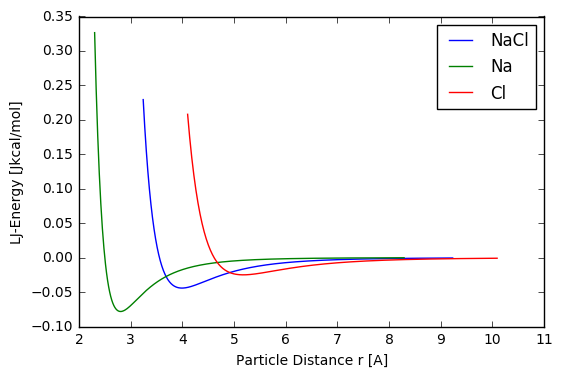

In [8]:
Image(filename='LJ_Potential.png')

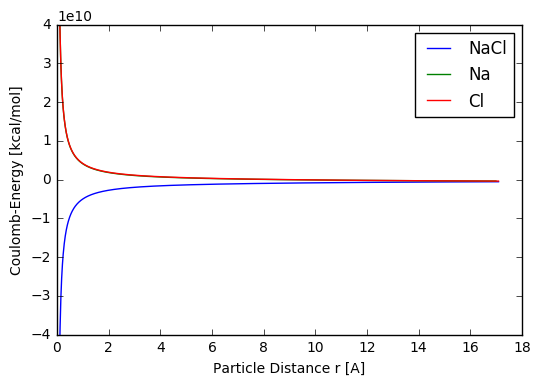

In [6]:
Image(filename='Coulomb_Potential.png')

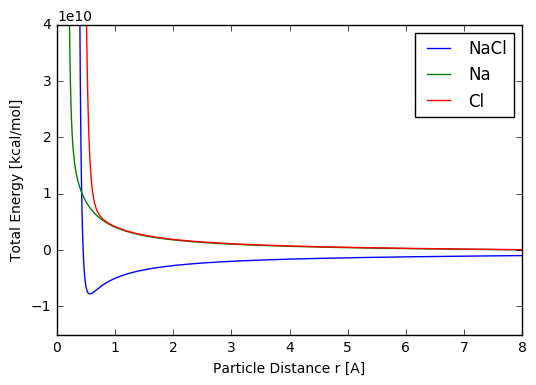

In [7]:
Image(filename='Total_Potential.png')

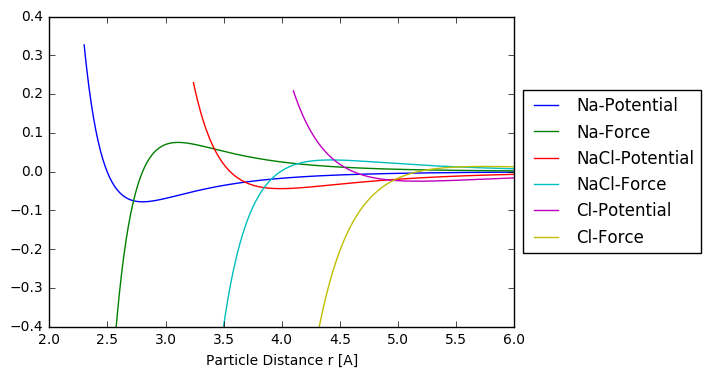

In [3]:
Image(filename='LJ_Potential_Force.png')

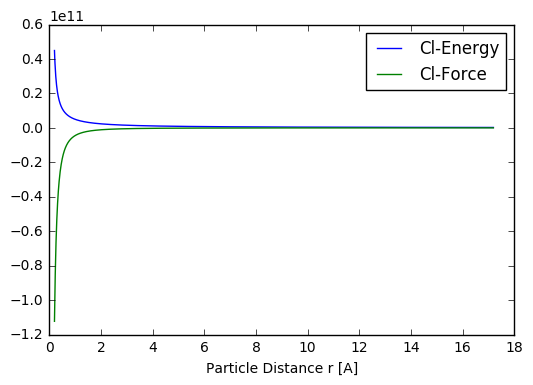

In [4]:
Image(filename='Coulomb_Potential_Force.png')

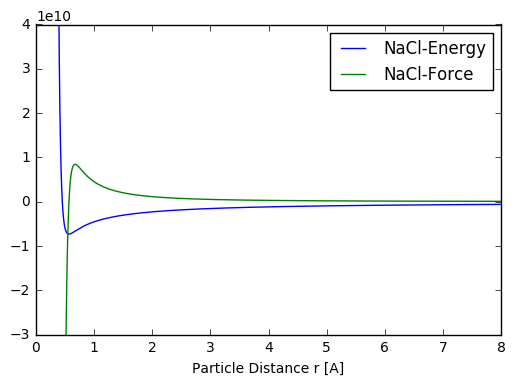

In [5]:
Image(filename='Total_Potential_Force.png')

### 2.1.2 Some Time Aspects

Single Shots
  
  
  Number fo particles  | L [A]| r_cut_coulomb [A] | r_cut_LJ [A]| p_error | number k-vector | Force | Energy | Neighbours
  -------------------- | --|     --------- | ---------|---------|-----------------|-------|--------|------------
 2 | 35.00 | 13.6 | 14.0 | 5 | 56 | 0.00162 s | 0.00091 s | 0.00130 s
 2                    | 35.00    | 13.4 |  14.0    |  10     | 618   |  0.00383 s  | 0.00216 s  | 0.00174 s 
 64 | 35.00 | 12.5 | 14.0 | 5 | 364 | 0.07834 s | 0.01054 s | 0.05375 s
 64 | 35.00 | 15.2 | 14.0 | 10 | 1364 | 0.17897 s | 0.02469 s | 0.04667 s
 1000 | 35.00 | 8.8 | 14.0 | 5 | 3868 | 51.09192 s | 1.03551 s | 1.07920 s
 1000 | 35.00 | 10.7 | 14.0 | 10 | 11772 | - | 1.92444 s | 4.39452 s

minimize_Energy 
 
 Number fo particles  | L [A]| r_cut_coulomb [A] | r_cut_LJ [A]| p_error | number k-vector | Steps | Time
  -------------------- | -----|------------------ | ------------|---------|-----------------|-------| -------
  2 | 35.00 | 13.6 | 14.0 | 10 | 618 | 100 | 0.44900 s 
  2 | 35.00 | 13.6 | 14.0 | 10 | 618 | 1000 | 4.35963 s
  2 | 35.00 | 13.6 | 14.0 | 10 | 618 | 1500 | 6.35155 s
  64| 35.00 | 15.2 | 14.0 | 10 | 1364 | 100 | 23.47219 s
  64| 35.00 | 15.2 | 14.0 | 10 | 1364 | 1000 | 3.5 min
  64| 35.00 | 15.2 | 14.0 | 10 | 1364 | 1500 | 6,1 min
  200 | 35.00 | 12.8 | 14.0 | 10 | 2720 | 100 | 4.7 min
  200 | 35.00 | 12.8 | 14.0 | 10 | 2720 | 1000 | 46.5 min
  200 | 35.00 | 12.8 | 14.0 | 10 | 2720 | 1500 | 68.4 min

get_traj

 Number fo particles  | L [A]| r_cut_coulomb [A] | r_cut_LJ [A]| p_error | number k-vector | Steps | Time
  -------------------- | -----|------------------ | ------------|---------|-----------------|-------| -------
  2 | 35.00 | 13.6 | 14.0 | 10 | 618 | 100 |  1.53299 s
  2 | 35.00 | 13.6 | 14.0 | 10 | 618 | 1000 | 14.71499 s
  2 | 35.00 | 13.6 | 14.0 | 10 | 618 | 1500 | 22.42100 s
  64| 35.00 | 15.2 | 14.0 | 10 | 1364 | 100 | 53.98399 s
  64| 35.00 | 15.2 | 14.0 | 10 | 1364 | 1000 | 9 min
  64| 35.00 | 15.2 | 14.0 | 10 | 1364 | 1500 | 13.1 min
  200 | 35.00 | 12.8 | 14.0 | 10 | 2776 | 100 | 6.1 min

### 2.1.3 Some simulations

Energy Minimization

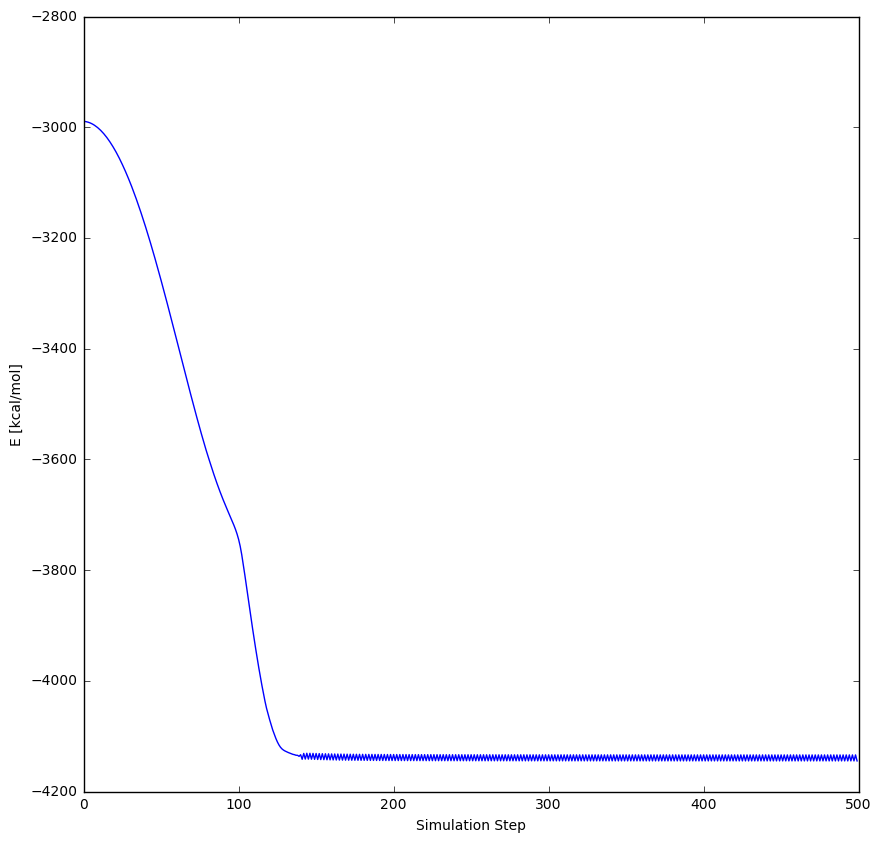

In [3]:
Image(filename='Minimize_energy.png')

Radial Distribution

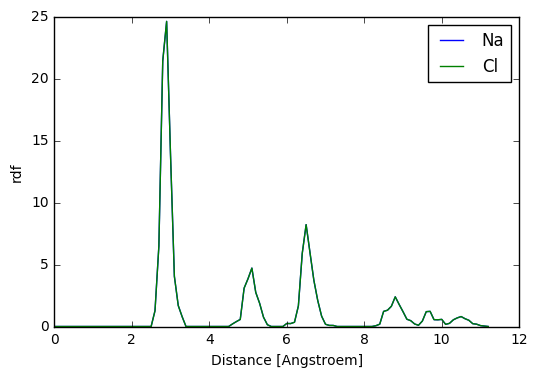

In [3]:
Image(filename='Radial_Distribution.png')

# Outlook

- improve computing time (especially long-range forces)

- other thermostats

- barostats

- analysis tools

- other integrators